# Results Optiwise inverse dynamics

In [1]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
#%load_ext kedro.ipython

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import sympy as sp
from sympy import Eq, symbols, latex
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess
from phd.visualization.plot_vct import plot_VCT, flat_keys

import paper
from paper import styles
from phd.visualization.units import units

In [3]:
ship_name = "optiwise"

In [4]:
loaders = {
    "polynomial rudder" : catalog.load(f"{ship_name}.models_VCT_polynomial_rudder_MDL")['simple'],
    "semiempirical rudder" : catalog.load(f"{ship_name}.models_VCT_MDL")['semiempirical_covered_inertia'],
}

[11/11/24 10:12:11] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=774599;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=884269;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/__ ]8;id=409052;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=789024;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             init__.py:44: KedroDeprecationWarning: 'AbstractDataSet' has been                     
                             renamed to 'AbstractDataset', and the alias will be removed in Kedro                  
                             0.19.0                                                                                
                               return getattr(kedro.io.core, name)                                                 
                                                                                                                   

                    INFO     Loading data from 'optiwise.models_VCT_polynomial_rudder_MDL'      ]8;id=34581;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=18073;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.models_VCT_MDL'                        ]8;id=463181;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=878658;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [5]:
models = {name:loader() for name,loader in loaders.items()}

## ID

In [6]:
meta_data_all = catalog.load(f"{ship_name}.time_series_meta_data")
id_exists = [int(key) for key in catalog.load(f"{ship_name}.tests_ek_smooth1").keys()]
#id_exists = [int(key) for key in catalog.load(f"{ship_name}.tests_ek1").keys()]

ids = sorted(list(set(id_exists) & set(meta_data_all.index)))

meta_data_all = meta_data_all.loc[ids].copy()
#ids = [int(key) for key in catalog.load("wPCC.tests_ek_smooth1").keys()]

mask = ((meta_data_all['test_type'] == 'zigzag') & (meta_data_all['ship_speed'] > 0.9))

meta_datas = meta_data_all.loc[mask].copy()

ids = [
    23590,
    23591,
    23594,
    23596,
]
meta_datas = meta_datas.loc[ids].copy()
meta_datas['angle'] = [
    -10,
    10,
    -20,
    20,
]

[11/11/24 10:12:31] INFO     Loading data from 'optiwise.time_series_meta_data' (CSVDataSet)... ]8;id=491902;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=158111;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=490959;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=866071;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=967514;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=346427;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=570455;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=731432;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

[11/11/24 10:12:32] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=391059;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=712258;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

[11/11/24 10:12:33] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=245070;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=667754;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=798155;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=170117;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

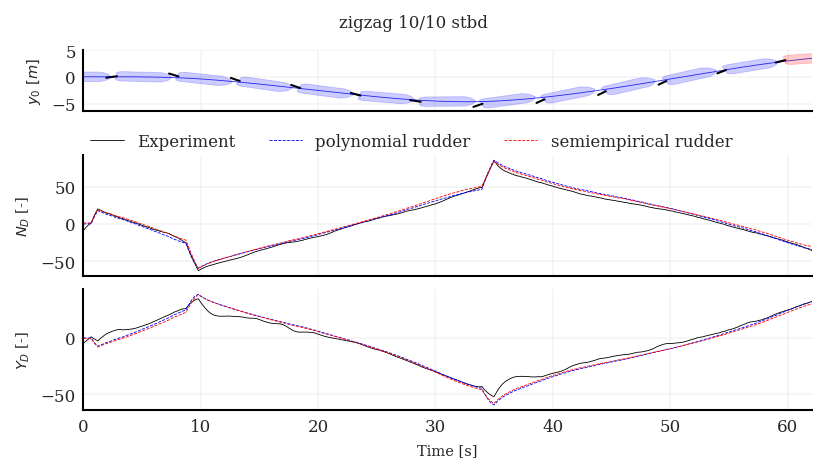

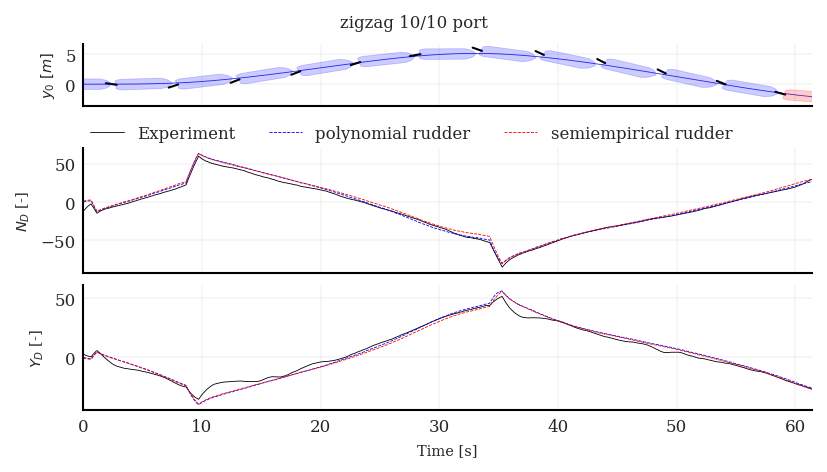

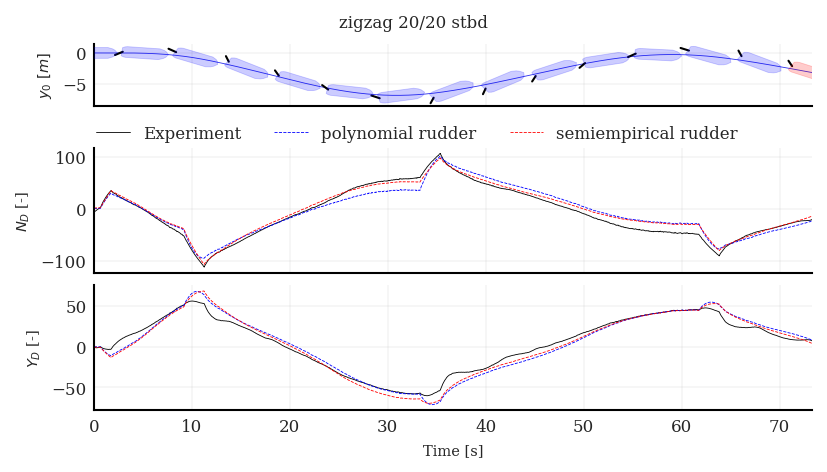

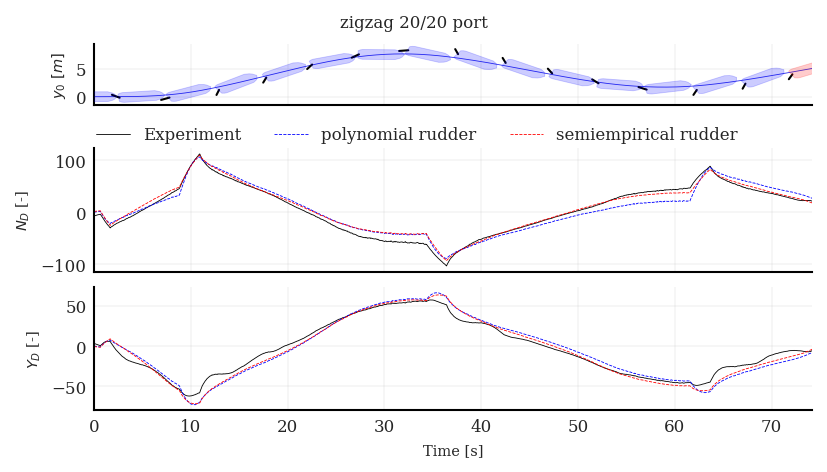

In [7]:
for id, meta_data in meta_datas.iterrows():

    df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
    df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)
    #df_EKF_smooth['thrust'] = df_EKF_smooth['thrust_port'] + df_EKF_smooth['thrust_stbd']
    #data = load(id=id, catalog=catalog, smooth=False)
    #data = filter(data,cutoff=1)
    #data = data.iloc[100:-100].copy()

    if id==22774:
        #data=data.loc[0:70].copy()
        df_EKF_smooth = df_EKF_smooth.loc[0:70].copy()


    fig = plot_compare_model_forces(model=models['polynomial rudder'], models=models, data=df_EKF_smooth, styles=styles, keys=['N_D','Y_D'], delta_corners=False);
    #fig = plot_compare_model_forces(model=models["ID small"], models=models, data=df_EKF_smooth, styles=styles, keys=['N_VCT','Y_VCT','N_H','N_R'], delta_corners=False);
    
    #fig.axes[-1].legend(loc='upper center', bbox_to_anchor=(0.05, 2.2), ncol=1)
    #fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.25, 2.2), ncol=3)
    fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.45, 1.30), ncol=3)
    #fig.axes[1].legend(bbox_to_anchor=(0.7, 1.5), ncol=5)
    #fig.axes[1].legend(ncol=3)
    
    for ax in fig.axes[1:5]:
        ylims = ax.get_ylim()
        ylims = [min([ylims[0],-30]), max([ylims[1],30]),]
        ax.set_ylim(ylims)
    
    direction = "port" if meta_data['angle'] > 0 else "stbd"
    name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction}"
    fig.suptitle(name)

    file_name = name.replace("/","_")
    paper.save_fig(fig, f"{file_name}.svg")


[11/11/24 10:12:36] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=172497;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=291269;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

<Axes: xlabel='time'>

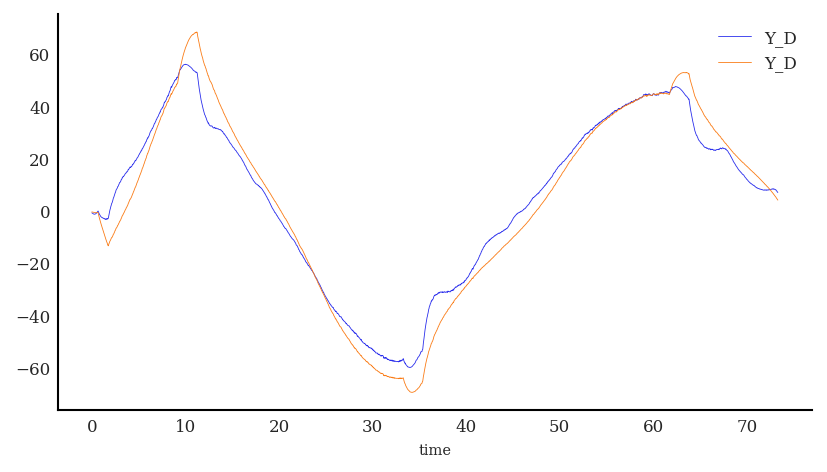

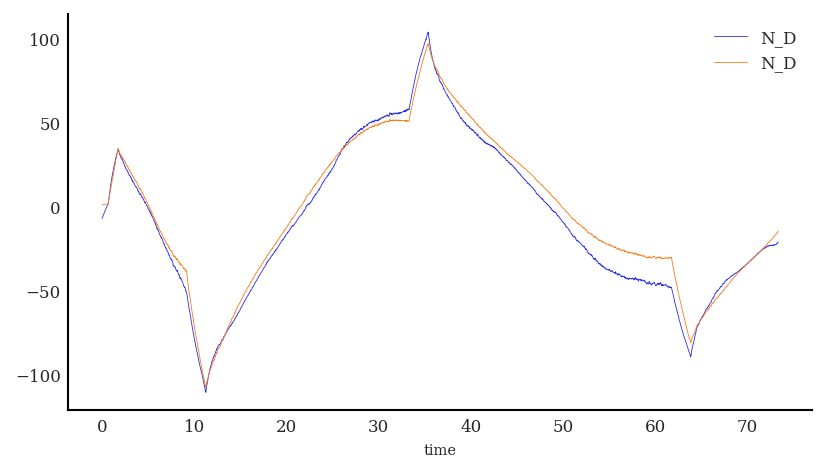

In [8]:


id=23594
df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)

fig,ax=plt.subplots()
models['semiempirical rudder'].forces_from_motions(df_EKF_smooth).plot(y='Y_D',ax=ax)
predict(model=models['semiempirical rudder'], data=df_EKF_smooth).plot(y='Y_D', ax=ax)

fig,ax=plt.subplots()
models['semiempirical rudder'].forces_from_motions(df_EKF_smooth).plot(y='N_D',ax=ax)
predict(model=models['semiempirical rudder'], data=df_EKF_smooth).plot(y='N_D', ax=ax)

## Closed loop simulation

[11/11/24 10:12:38] INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=796491;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=770770;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=288604;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=757650;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=108910;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=96938;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/11/24 10:12:39] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=510751;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=620069;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/11/24 10:12:40] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=147142;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=892427;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=343479;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=903327;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/11/24 10:12:41] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=561124;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=658651;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/11/24 10:12:42] WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=652832;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=48572;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:133: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=234020;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=753380;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=994965;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=127746;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=307329;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=556190;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/11/24 10:12:43] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=475787;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=262903;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=108771;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=257702;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=369019;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=529572;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/11/24 10:12:44] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=901623;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=537435;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/11/24 10:12:45] WARNING  No artists with labels found to put in legend.  Note that artists whose ]8;id=32605;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py\legend.py]8;;\:]8;id=385979;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py#1363\1363]8;;\
                             label start with an underscore are ignored when legend() is called with               
                             no argument.                                                                          

                    WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=137611;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=448920;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:133: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=133686;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=246173;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=273672;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=217152;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=343755;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=678441;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/11/24 10:12:46] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=447955;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=885650;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=653538;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=698784;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=980676;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=769497;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/11/24 10:12:47] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=668363;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=318526;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/11/24 10:12:48] WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=448943;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=783607;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:133: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

                    INFO     Loading data from 'optiwise.tests_ek_smooth1'                      ]8;id=586837;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=880644;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=362421;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=593154;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=452581;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=74896;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/11/24 10:12:49] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=642940;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=96675;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=143823;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=923315;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/11/24 10:12:50] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=995883;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=935481;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/scipy/integ ]8;id=892300;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=846384;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rate/_ivp/ivp.py:621: UserWarning: The following arguments have no                    
                             effect for a chosen solver: `name`.                                                   
                               solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)                  
                                                                                                                   

[11/11/24 10:12:51] WARNING  No artists with labels found to put in legend.  Note that artists whose ]8;id=709116;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py\legend.py]8;;\:]8;id=71288;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/matplotlib/legend.py#1363\1363]8;;\
                             label start with an underscore are ignored when legend() is called with               
                             no argument.                                                                          

                    WARNING  /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/visual ]8;id=400933;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=98458;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ization/plot.py:133: UserWarning: The figure layout has changed to                    
                             tight                                                                                 
                               plt.tight_layout()                                                                  
                                                                                                                   

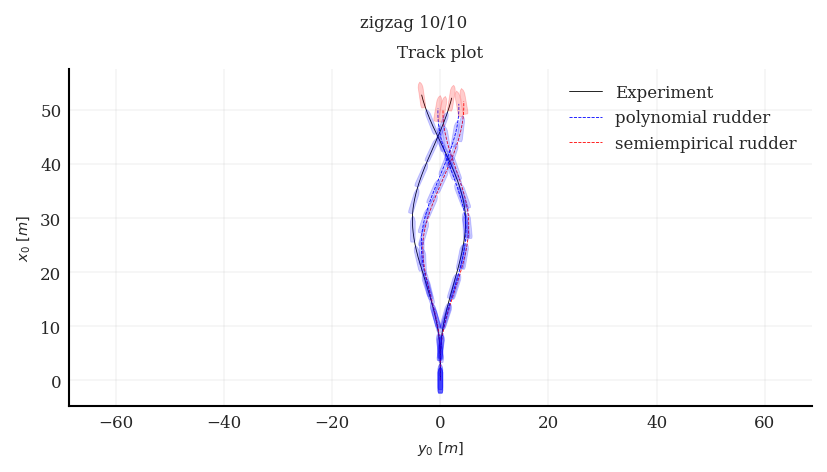

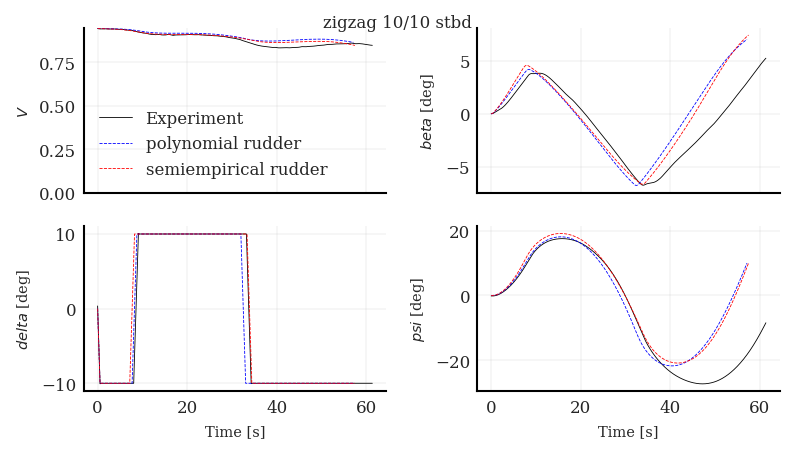

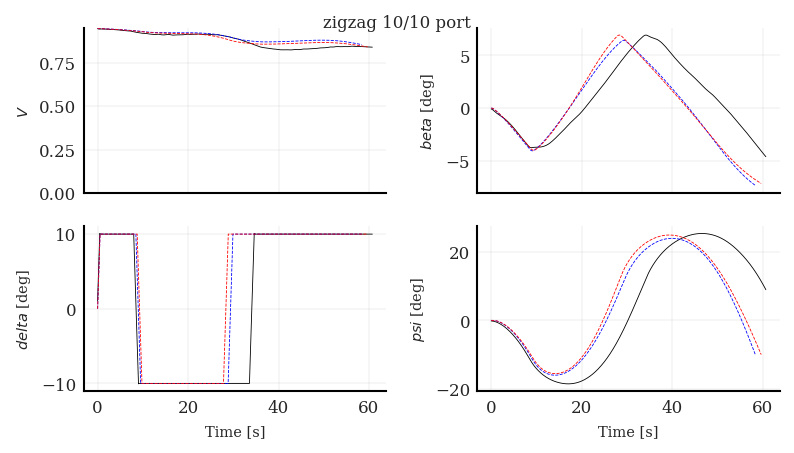

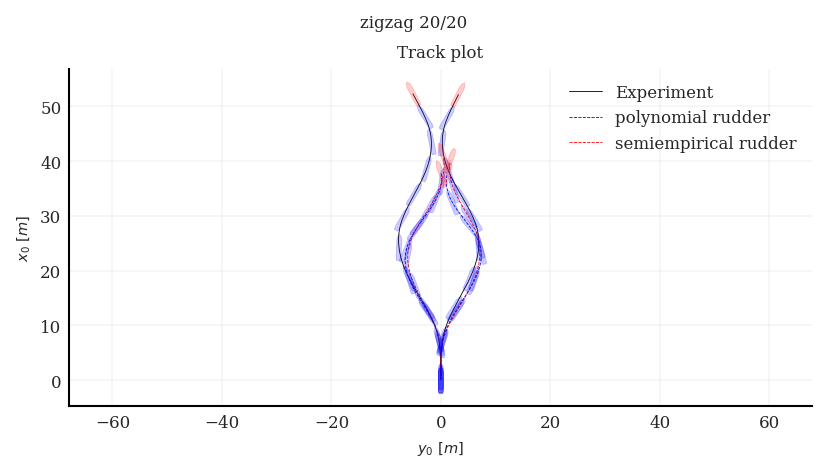

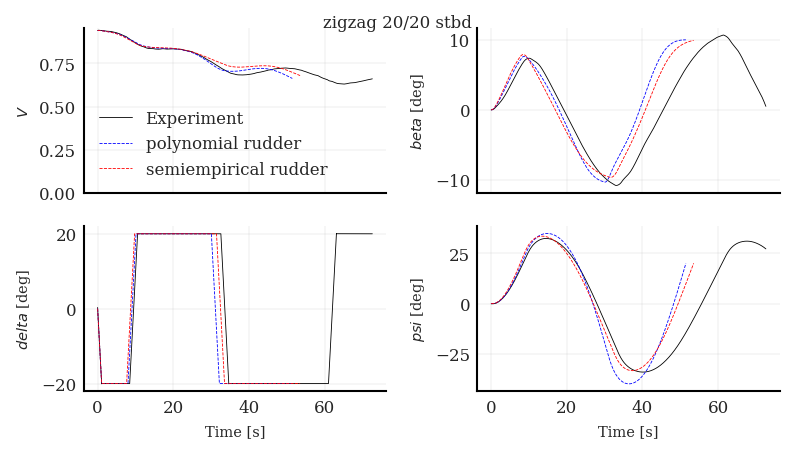

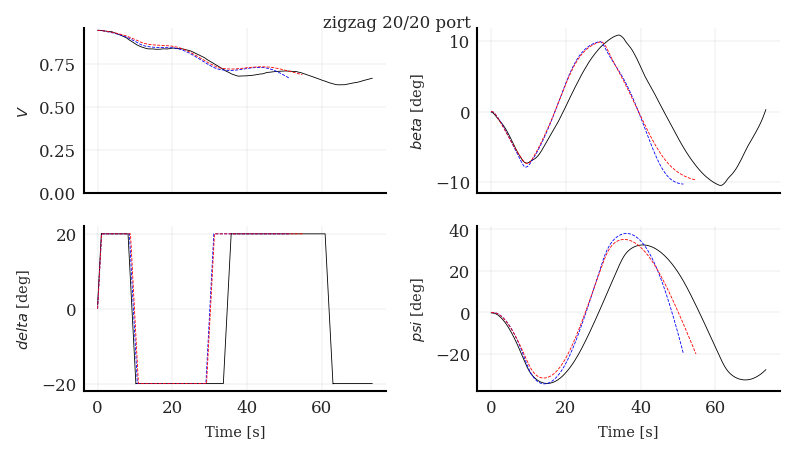

In [9]:
for angle, group in meta_datas.groupby(by='angle1'):

    fig,ax=plt.subplots()
    include_label=True
    
    for id, meta_data in group.iterrows():
    
        df_EKF_smooth = catalog.load(f"{ship_name}.tests_ek_smooth1")[str(id)]()
        df_EKF_smooth['U'] = np.sqrt(df_EKF_smooth['u']**2 + df_EKF_smooth['v']**2)
    
        dataframes = {'Experiment':df_EKF_smooth}
        
        for model_name, model in models.items():
        
            data = preprocess(df_EKF_smooth,ship_data=model.ship_parameters)
            #angle = zigzag_angle(data_MDL=data)
        
            df_simulation = simulate_closed_loop(model=model,data=data)
        
            direction = "port" if meta_data['angle'] > 0 else "stbd"
            name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction} {model_name}"
        
            dataframes[model_name] = df_simulation
    
        track_plots(dataframes, lpp=model.ship_parameters['L'], beam=model.ship_parameters['B'], include_wind=False, styles=styles, ax=ax, include_label=include_label);
        fig = ax.get_figure()
        direction = "port" if meta_data['angle'] > 0 else "stbd"
        name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f}"
        fig.suptitle(name)
        file_name = name.replace("/","_")
        paper.save_fig(fig, f"track plot {file_name}.svg")
        
        fig = plot(dataframes, keys=['psi','beta','V','delta'], units=units, styles=styles, ncols=2, include_label=include_label);
        name = f"{meta_data['test_type']} {meta_data['angle1']:0.0f}/{meta_data['angle1']:0.0f} {direction}"
        fig.suptitle(name)
        file_name = name.replace("/","_")
        paper.save_fig(fig, f"closed loop {file_name}.svg")
        
        
        include_label=False

In [10]:
styles


{
    'Experiment': {'style': 'k-', 'label': 'Experiment'},
    'polynomial rudder': {'style': 'b--', 'label': 'polynomial rudder'},
    'semiempirical rudder': {'style': 'r--', 'label': 'semiempirical rudder'}
}